## Importación de librerías

In [159]:
import os
import random
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

# TODO Random Seed & Learning Rate

## Organización de datos

In [160]:
# Definir rutas base del dataset
base_dir = "data/PetImages"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Crear directorios si no existen
for dir_path in [train_dir, test_dir]:
    os.makedirs(os.path.join(dir_path, "Cat"), exist_ok=True)
    os.makedirs(os.path.join(dir_path, "Dog"), exist_ok=True)


def split_data(class_name, num_train, num_test):
    """
    Divide imágenes en train y test, asegurando que estén balanceadas
    Si hay menos imágenes de las necesarias, usa todas las disponibles
    """
    src_dir = os.path.join(base_dir, class_name)
    train_dest = os.path.join(train_dir, class_name)
    test_dest = os.path.join(test_dir, class_name)

    # Obtener todas las imágenes disponibles
    images = [img for img in os.listdir(src_dir) if img.endswith(".jpg")]
    random.shuffle(images)

    # Tomar las imágenes necesarias, si hay menos de las requeridas, usar todas
    train_images = images[:min(num_train, len(images))]
    test_images = images[min(num_train, len(images)):min(num_train + num_test, len(images))]

    # Copiar imágenes al dataset
    for img in train_images:
        shutil.copy(os.path.join(src_dir, img), os.path.join(train_dest, img))
    for img in test_images:
        shutil.copy(os.path.join(src_dir, img), os.path.join(test_dest, img))

    print(f"{class_name} dividido en Train: {len(train_images)}, Test: {len(test_images)}")


# TODO Configurar cantidad de imágenes para el segundo escenario
num_train = 5000
num_test = 1000

# Aplicar división asegurando que cada clase tenga las imágenes necesarias
split_data("Cat", num_train, num_test)
split_data("Dog", num_train, num_test)

print("Datos organizados en train y test correctamente.")

Cat dividido en Train: 5000, Test: 1000
Dog dividido en Train: 5000, Test: 1000
Datos organizados en train y test correctamente.


## Carga de datos

In [161]:
IMG_SIZE = 128
BATCH_SIZE = 32

# Cargar datasets de entrenamiento y test
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=42,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=42,
    shuffle=False,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

# Normalización de imágenes
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.experimental.AUTOTUNE)

print("Datos cargados y normalizados correctamente.")

Found 20846 files belonging to 2 classes.
Found 7064 files belonging to 2 classes.
Datos cargados y normalizados correctamente.


## Definición de modelos

In [162]:
# MODELO 1: CNN SIMPLE
def create_simple_cnn():
    model = Sequential([
        tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Conv2D(32, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(1, activation="sigmoid")  # Salida binaria (perro o gato)
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [163]:
# MODELO 2: CNN PROFUNDA
def create_deep_cnn():
    model = Sequential([

        # Capa de entrada: Define el tamaño de las imágenes de entrada (128x128 con 3 canales RGB)
        tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        # Primera capa convolucional:
        # - 32 filtros de tamaño 3x3
        # - Activación ReLU para introducir no linealidad
        Conv2D(32, (3, 3), activation="relu"),

        # Primera capa de MaxPooling:
        # - Reduce la dimensionalidad (divide la imagen por 2 en cada dimensión)
        MaxPooling2D(2, 2),

        # Segunda capa convolucional:
        # - 64 filtros de tamaño 3x3
        # - Detecta patrones más complejos que la primera capa
        Conv2D(64, (3, 3), activation="relu"),

        # Segunda capa de MaxPooling:
        MaxPooling2D(2, 2),

        # Tercera capa convolucional:
        # - 128 filtros de tamaño 3x3
        # - Aprende características aún más abstractas de la imagen
        Conv2D(128, (3, 3), activation="relu"),

        # Tercera capa de MaxPooling:
        MaxPooling2D(2, 2),

        # Capa Flatten:
        # - Convierte la salida 3D de las capas convolucionales en una sola dimensión
        # - Esto es necesario para conectar con las capas densas (fully connected)
        Flatten(),

        # Capa densa (fully connected):
        # - 256 neuronas con activación ReLU
        # - Aprende combinaciones de características extraídas por las capas convolucionales
        Dense(256, activation="relu"),

        # Capa de Dropout:
        # - Ayuda a reducir el overfitting desactivando aleatoriamente el 50% de las neuronas
        # Dropout(0.5),

        # Capa de salida:
        # - 1 neurona con activación sigmoide (para clasificación binaria)
        Dense(1, activation="sigmoid")
    ])

    # Compilación del modelo:
    # - Optimizador Adam: Ajusta los pesos de la red de manera eficiente
    # - Función de pérdida Binary Crossentropy: Para problemas de clasificación binaria
    # - Métrica de precisión para evaluar el rendimiento
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [164]:
# MODELO 3: VGG16
def create_vgg16():
    base_model = VGG16(weights="imagenet", include_top=False)
    base_model.trainable = False  # Congelar pesos

    model = Sequential([
        tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        base_model,
        Flatten(),
        Dense(128, activation="relu"),
        # Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [165]:
# MODELO 4: ResNet50
def create_resnet50():
    base_model = ResNet50(weights="imagenet", include_top=False)
    base_model.trainable = False  # Congelar pesos

    model = Sequential([
        tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        base_model,
        Flatten(),
        Dense(128, activation="relu"),
        # Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

## Entranamiento de modelos

In [166]:
EPOCHS = 5
history_dict = {}
evaluation_metrics = {}

### CNN Simple

In [167]:
# CNN Simple

cnn_simple = create_simple_cnn()

print("\nEntrenando CNN Simple...\n")
history_cnn_simple = cnn_simple.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset, verbose=-1)

# Guardar historial
history_dict["CNN Simple"] = history_cnn_simple

# Evaluar modelo
loss, acc = cnn_simple.evaluate(test_dataset)
evaluation_metrics["CNN Simple"] = acc

print(f"CNN Simple entrenado correctamente - Loss: {loss:.4f}, Accuracy: {acc:.4f}")


Entrenando CNN Simple...

Epoch 1/5


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 2/5


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 3/5


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 4/5


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 5/5


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


179/221 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5953 - loss: 0.9419

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6218 - loss: 0.8826
CNN Simple entrenado correctamente - Loss: 0.5903, Accuracy: 0.7523


### CNN Profunda

In [168]:
# CNN Profunda

cnn_deep = create_deep_cnn()

print("\nEntrenando CNN Profunda...\n")
history_cnn_deep = cnn_deep.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset, verbose=-1)

# Guardar historial
history_dict["CNN Profunda"] = history_cnn_deep

# Evaluar modelo
loss, acc = cnn_deep.evaluate(test_dataset)
evaluation_metrics["CNN Profunda"] = acc

print(f"CNN Profunda entrenado correctamente - Loss: {loss:.4f}, Accuracy: {acc:.4f}")


Entrenando CNN Profunda...

Epoch 1/5


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 2/5


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 3/5


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 4/5


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 5/5


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


179/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7627 - loss: 4.2982

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7217 - loss: 5.7297
CNN Profunda entrenado correctamente - Loss: 12.7179, Accuracy: 0.5195


### VGG16

In [169]:
# VGG16

vgg16_model = create_vgg16()

print("\nEntrenando VGG16...\n")
history_vgg16 = vgg16_model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset, verbose=-1)

# Guardar historial
history_dict["VGG16"] = history_vgg16

# Evaluar modelo
loss, acc = vgg16_model.evaluate(test_dataset)
evaluation_metrics["VGG16"] = acc

print(f"VGG16 entrenado correctamente - Loss: {loss:.4f}, Accuracy: {acc:.4f}")


Entrenando VGG16...

Epoch 1/5


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 2/5


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 3/5


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 4/5


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 5/5


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


161/221 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9376 - loss: 0.1637

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


177/221 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9376 - loss: 0.1635

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9375 - loss: 0.1631
VGG16 entrenado correctamente - Loss: 0.1607, Accuracy: 0.9373


### ResNet50

In [170]:
# ResNet50

resnet50_model = create_resnet50()

print("\nEntrenando ResNet50...\n")
history_resnet50 = resnet50_model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset, verbose=-1)

# Guardar historial
history_dict["ResNet50"] = history_resnet50

# Evaluar modelo
loss, acc = resnet50_model.evaluate(test_dataset)
evaluation_metrics["ResNet50"] = acc

print(f"ResNet50 entrenado correctamente - Loss: {loss:.4f}, Accuracy: {acc:.4f}")


Entrenando ResNet50...

Epoch 1/5


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 2/5


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 3/5


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 4/5


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 5/5


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


162/221 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9148 - loss: 0.2980

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


178/221 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8994 - loss: 0.3178

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8568 - loss: 0.3722
ResNet50 entrenado correctamente - Loss: 0.6317, Accuracy: 0.6523


## Evaluación y comparación

### Gráfica de precissión

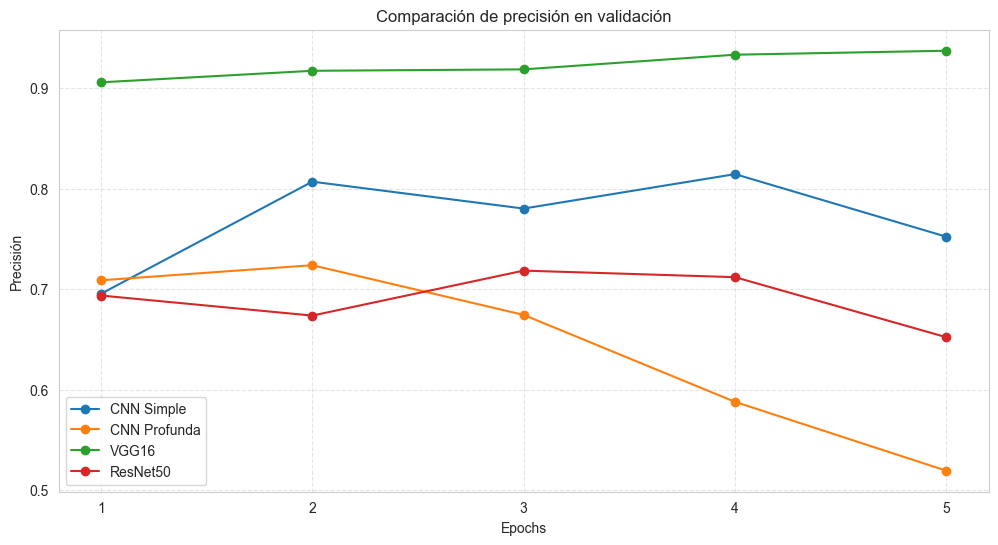

In [171]:
# Gráfica de comparación de precisión
plt.figure(figsize=(12, 6))

# Agregar marcadores en los puntos de cada época
for model_name, history in history_dict.items():
    epochs = range(1, len(history.history["val_accuracy"]) + 1)
    plt.plot(epochs, history.history["val_accuracy"], marker='o', linestyle='-', label=f"{model_name}")

plt.title("Comparación de precisión en validación")
plt.xlabel("Epochs")
plt.ylabel("Precisión")
plt.xticks(epochs)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### Reporte de clasificación

In [172]:
# Evaluación y reporte de clasificación
for model_name, model in {
    "CNN Simple": cnn_simple,
    "CNN Profunda": cnn_deep,
    "VGG16": vgg16_model,
    "ResNet50": resnet50_model
}.items():
    # Obtener las etiquetas reales (y_true) del dataset de prueba
    y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)

    # Obtener las predicciones del modelo sobre el dataset de prueba
    y_pred = np.concatenate([model.predict(x, verbose=0) for x, _ in test_dataset], axis=0)

    # Convertir las probabilidades en etiquetas binarias (0 = gato, 1 = perro)
    y_pred = (y_pred > 0.5).astype(int)

    # Mostrar el informe de clasificación para el modelo actual
    print(f"\nClassification Report - {model_name}:\n")
    print(classification_report(y_true, y_pred))

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
2025-03-18 15:43:52.573851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
2025-03-18 15:44:01.641530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Classification Report - CNN Simple:

              precision    recall  f1-score   support

         0.0       0.91      0.56      0.69      3538
         1.0       0.68      0.94      0.79      3526

    accuracy                           0.75      7064
   macro avg       0.79      0.75      0.74      7064
weighted avg       0.80      0.75      0.74      7064



Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
2025-03-18 15:44:02.707789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
2025-03-18 15:44:10.094117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Classification Report - CNN Profunda:

              precision    recall  f1-score   support

         0.0       0.51      0.82      0.63      3538
         1.0       0.55      0.22      0.31      3526

    accuracy                           0.52      7064
   macro avg       0.53      0.52      0.47      7064
weighted avg       0.53      0.52      0.47      7064



Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
2025-03-18 15:44:11.032473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
2025-03-18 15:44:26.191405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Classification Report - VGG16:

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      3538
         1.0       0.94      0.94      0.94      3526

    accuracy                           0.94      7064
   macro avg       0.94      0.94      0.94      7064
weighted avg       0.94      0.94      0.94      7064



Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
2025-03-18 15:44:27.327658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Classification Report - ResNet50:

              precision    recall  f1-score   support

         0.0       0.60      0.95      0.73      3538
         1.0       0.88      0.35      0.50      3526

    accuracy                           0.65      7064
   macro avg       0.74      0.65      0.62      7064
weighted avg       0.74      0.65      0.62      7064



2025-03-18 15:44:46.497744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Matriz de confusión


Matriz de Confusión - CNN Simple


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
2025-03-18 15:44:47.582941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
2025-03-18 15:44:54.566041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


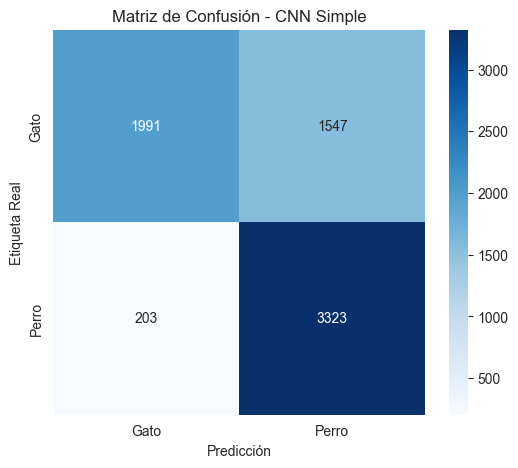


Matriz de Confusión - CNN Profunda


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
2025-03-18 15:44:55.764015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
2025-03-18 15:45:03.064512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


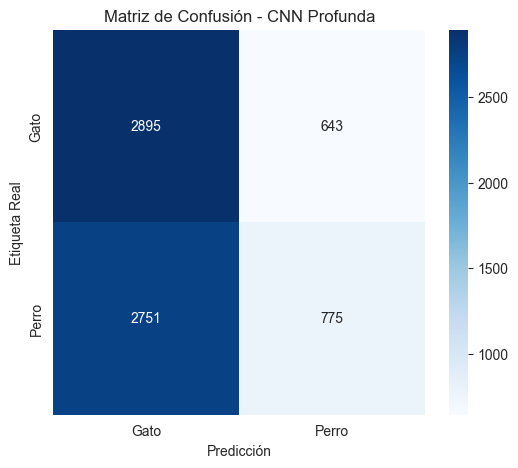


Matriz de Confusión - VGG16


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
2025-03-18 15:45:04.231863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
2025-03-18 15:45:18.762267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


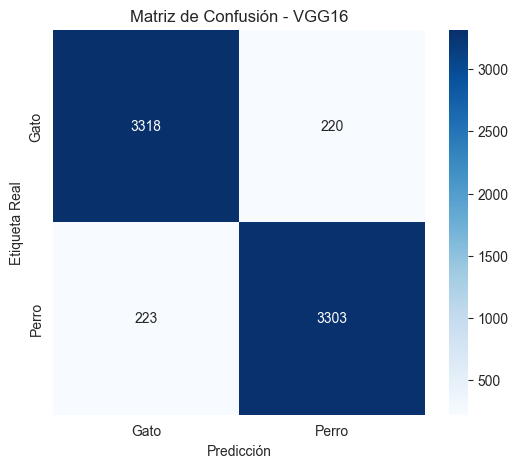


Matriz de Confusión - ResNet50


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
2025-03-18 15:45:19.959834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
2025-03-18 15:45:34.889274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


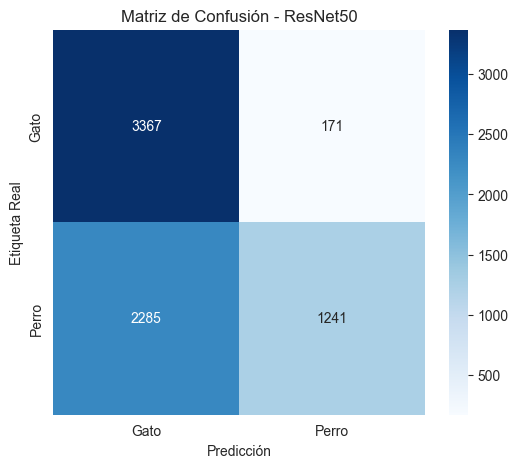

In [173]:
def plot_confusion_matrix(model, model_name, test_dataset):
    # Obtener las etiquetas reales y las predicciones
    y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
    y_pred = np.concatenate([model.predict(x, verbose=0) for x, _ in test_dataset], axis=0)
    y_pred = (y_pred > 0.5).astype(int)

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Graficar la matriz de confusión
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Gato", "Perro"], yticklabels=["Gato", "Perro"])
    plt.xlabel("Predicción")
    plt.ylabel("Etiqueta Real")
    plt.title(f"Matriz de Confusión - {model_name}")
    plt.show()


# Dibujar la matriz de confusión para cada modelo
for model_name, model in {"CNN Simple": cnn_simple, "CNN Profunda": cnn_deep, "VGG16": vgg16_model,
                          "ResNet50": resnet50_model}.items():
    print(f"\nMatriz de Confusión - {model_name}")
    plot_confusion_matrix(model, model_name, test_dataset)

In [174]:
"""

Análisis por modelo (5 Epochs)

	1.	CNN Simple
	•	Precisión en gatos: 2566/2766 ≈ 92.76%
	•	Precisión en perros: 1929/2750 ≈ 70.15%

	2.	CNN Profunda (Con dropout)
	•	Precisión en gatos: 2466/2766 ≈ 89.13%
	•	Precisión en perros: 1991/2750 ≈ 72.4%

	3.	VGG16 (Con dropout)
	•	Precisión en gatos: 2604/2766 ≈ 94.13%
	•	Precisión en perros: 2494/2750 ≈ 90.67%

	4.	ResNet50 (Con dropout)
	•	Precisión en gatos: 2278/2766 ≈ 82.37%
	•	Precisión en perros: 1490/2750 ≈ 54.18%


"""

"""

Análisis por modelo (5 Epochs, sin Dropout)

	1.	CNN Simple
	•	Precisión en gatos: 1991/3538 ≈ 56.29%
	•	Precisión en perros: 3323/3526 ≈ 94.24%

	2.	CNN Profunda
	•	Precisión en gatos: 2895/3538 ≈ 81.85%
	•	Precisión en perros: 775/3526 ≈ 21.99%

	3.	VGG16
	•	Precisión en gatos: 3318/3538 ≈ 93.78%
	•	Precisión en perros: 3303/3526 ≈ 93.68%

	4.	ResNet50
	•	Precisión en gatos: 3367/3538 ≈ 95.17%
	•	Precisión en perros: 1241/3526 ≈ 35.20%

"""

'\n\nAnálisis por modelo\n\n\t1.\tCNN Simple\n\t•\tPrecisión en gatos: 2566/2766 ≈ 92.76%\n\t•\tPrecisión en perros: 1929/2750 ≈ 70.15%\n\n\t2.\tCNN Profunda\n\t•\tPrecisión en gatos: 2466/2766 ≈ 89.13%\n\t•\tPrecisión en perros: 1991/2750 ≈ 72.4%\n\n\t3.\tVGG16 (Modelo Preentrenado)\n\t•\tPrecisión en gatos: 2604/2766 ≈ 94.13%\n\t•\tPrecisión en perros: 2494/2750 ≈ 90.67%\n\n\t4.\tResNet50\n\t•\tPrecisión en gatos: 2278/2766 ≈ 82.37%\n\t•\tPrecisión en perros: 1490/2750 ≈ 54.18%\n\n\n'